In [1]:
from Tbx_Sample import *

In [2]:
import os
import sys
import socket
import torch.multiprocessing

import copy

torch.multiprocessing.set_sharing_strategy('file_system')
import warnings

warnings.filterwarnings("ignore")

conf_path = os.getcwd()
sys.path.append(conf_path)
sys.path.append(conf_path + '/datasets')
sys.path.append(conf_path + '/backbone')
sys.path.append(conf_path + '/models')
from datasets import Priv_NAMES as DATASET_NAMES
from models import get_all_models
from argparse import ArgumentParser
from utils.args import add_management_args
from datasets import get_prive_dataset
from models import get_model
from utils.training import train
from utils.best_args import best_args
from utils.conf import set_random_seed
import setproctitle

import torch
import uuid
import datetime

In [13]:
def parse_args():
    parser = ArgumentParser(description='You Only Need Me', allow_abbrev=False)
    parser.add_argument('--device_id', type=int, default=0, help='The Device Id for Experiment')

    parser.add_argument('--communication_epoch', type=int, default=10, help='The Communication Epoch in Federated Learning')
    parser.add_argument('--local_epoch', type=int, default=1, help='The Local Epoch for each Participant')
    parser.add_argument('--parti_num', type=int, default=3, help='The Number for Participants')

    parser.add_argument('--seed', type=int, default=0, help='The random seed.')
    parser.add_argument('--rand_dataset', type=dict, default={ 'caltech': 3,'amazon': 2,'webcam':1, 'dslr': 4,
                                                              'mnist': 3, 'syn': 2, 'usps': 2, 'svhn': 3}, help='The random seed.')

    parser.add_argument('--model', type=str, default='fpl',  # moon fedinfonce
                        help='Model name.', choices=get_all_models())
    parser.add_argument('--structure', type=str, default='homogeneity')
    parser.add_argument('--dataset', type=str, default='fl_digits',  # fl_officecaltech fl_digits
                        choices=DATASET_NAMES, help='Which scenario to perform experiments on.')

    parser.add_argument('--pri_aug', type=str, default='weak',  # weak strong
                        help='Augmentation for Private Data')
    parser.add_argument('--online_ratio', type=float, default=1, help='The Ratio for Online Clients')
    parser.add_argument('--learning_decay', type=bool, default=False, help='The Option for Learning Rate Decay')
    parser.add_argument('--averaing', type=str, default='weight', help='The Option for averaging strategy')

    parser.add_argument('--infoNCET', type=float, default=0.02, help='The InfoNCE temperature')
    parser.add_argument('--T', type=float, default=0.05, help='The Knowledge distillation temperature')
    parser.add_argument('--weight', type=int, default=1, help='The Wegith for the distillation loss')

    parser.add_argument('--reserv_ratio', type=float, default=0.1, help='Reserve ratio for prototypes')

    torch.set_num_threads(4)
    def add_management_args(parser: ArgumentParser) -> None:
        parser.add_argument('--csv_log', action='store_true',
                            help='Enable csv logging',default=False)
    
    add_management_args(parser)
    
    args, unknown = parser.parse_known_args()

    best = best_args[args.dataset][args.model]

    for key, value in best.items():
        setattr(args, key, value)

    if args.seed is not None:
        set_random_seed(args.seed)
    return args

In [14]:
args = parse_args()

priv_dataset = get_prive_dataset(args)

In [15]:
priv_dataset.train_loaders

[]

In [16]:
print(vars(priv_dataset))

{'train_loaders': [], 'test_loader': [], 'args': Namespace(device_id=0, communication_epoch=10, local_epoch=1, parti_num=3, seed=0, rand_dataset={'caltech': 3, 'amazon': 2, 'webcam': 1, 'dslr': 4, 'mnist': 3, 'syn': 2, 'usps': 2, 'svhn': 3}, model='fpl', structure='homogeneity', dataset='fl_digits', pri_aug='weak', online_ratio=1, learning_decay=False, averaing='weight', infoNCET=0.02, T=0.05, weight=1, reserv_ratio=0.1, csv_log=False, local_lr=0.01, local_batch_size=64, Note='+ MSE')}


In [17]:
backbones_list = priv_dataset.get_backbone(args.parti_num, None)

In [18]:
model = get_model(backbones_list, args, priv_dataset.get_transform())

In [19]:
# print(vars(model))

In [20]:
import torch
from argparse import Namespace
from models.utils.federated_model import FederatedModel
from datasets.utils.federated_dataset import FederatedDataset
from typing import Tuple
from torch.utils.data import DataLoader
import numpy as np
from utils.logger import CsvWriter
from collections import Counter


def global_evaluate(model: FederatedModel, test_dl: DataLoader, setting: str, name: str) -> Tuple[list, list]:
    accs = []
    net = model.global_net
    status = net.training
    net.eval()
    for j, dl in enumerate(test_dl):
        correct, total, top1, top5 = 0.0, 0.0, 0.0, 0.0
        for batch_idx, (images, labels) in enumerate(dl):
            with torch.no_grad():
                images, labels = images.to(model.device), labels.to(model.device)
                outputs = net(images)
                _, max5 = torch.topk(outputs, 5, dim=-1)
                labels = labels.view(-1, 1)
                top1 += (labels == max5[:, 0:1]).sum().item()
                top5 += (labels == max5).sum().item()
                total += labels.size(0)
        top1acc = round(100 * top1 / total, 2)
        top5acc = round(100 * top5 / total, 2)
        # if name in ['fl_digits','fl_officecaltech']:
        accs.append(top1acc)
        # elif name in ['fl_office31','fl_officehome']:
        #     accs.append(top5acc)
    net.train(status)
    return accs


def train(model: FederatedModel, private_dataset: FederatedDataset, args: Namespace) -> None:
    if args.csv_log:
        csv_writer = CsvWriter(args, private_dataset)

    model.N_CLASS = private_dataset.N_CLASS
    domains_list = private_dataset.DOMAINS_LIST
    domains_len = len(domains_list)

    if args.rand_dataset:
        max_num = 10
        is_ok = False

        while not is_ok:
            if model.args.dataset == 'fl_officecaltech':
                selected_domain_list = np.random.choice(domains_list, size=args.parti_num - domains_len, replace=True, p=None)
                selected_domain_list = list(selected_domain_list) + domains_list
            elif model.args.dataset == 'fl_digits':
                selected_domain_list = np.random.choice(domains_list, size=args.parti_num, replace=True, p=None)

            result = dict(Counter(selected_domain_list))

            for k in result:
                if result[k] > max_num:
                    is_ok = False
                    break
            else:
                is_ok = True
    else:
        selected_domain_dict = {'mnist': 6, 'usps': 4, 'svhn': 3, 'syn': 7}  # base
        selected_domain_dict = {'mnist': 3, 'usps': 7, 'svhn': 6, 'syn': 4}  # article

        # selected_domain_dict = {'mnist': 1, 'usps': 1, 'svhn': 9, 'syn': 9}  # 20

        # selected_domain_dict = {'mnist': 3, 'usps': 2, 'svhn': 1, 'syn': 4}  # 10

        selected_domain_list = []
        for k in selected_domain_dict:
            domain_num = selected_domain_dict[k]
            for i in range(domain_num):
                selected_domain_list.append(k)

        selected_domain_list = np.random.permutation(selected_domain_list)

        result = Counter(selected_domain_list)
    print(result)

    print(selected_domain_list)
    pri_train_loaders, test_loaders, federation = private_dataset.get_data_loaders(selected_domain_list)
    model.trainloaders = pri_train_loaders
    if hasattr(model, 'ini'):
        model.ini()

    accs_dict = {}
    mean_accs_list = []

    domain_to_index = {domain: idx for idx, domain in enumerate(domains_list)}
    mapped_indexes = [domain_to_index[domain] for domain in selected_domain_list]

    Epoch = args.communication_epoch
    for epoch_index in range(Epoch):
        model.epoch_index = epoch_index
        if hasattr(model, 'loc_update'):
            epoch_loc_loss_dict = model.loc_update(pri_train_loaders, test_loaders, mapped_indexes, epoch_index)

        accs = global_evaluate(model, test_loaders, private_dataset.SETTING, private_dataset.NAME)
        mean_acc = round(np.mean(accs, axis=0), 3)
        mean_accs_list.append(mean_acc)
        for i in range(len(accs)):
            if i in accs_dict:
                accs_dict[i].append(accs[i])
            else:
                accs_dict[i] = [accs[i]]

        print('The ' + str(epoch_index) + ' Communcation Accuracy:', str(mean_acc), 'Method:', model.args.model)
        print(accs)

    if args.csv_log:
        csv_writer.write_acc(accs_dict, mean_accs_list)
        
    return federation


In [21]:
# The 49 Communcation Accuracy: 74.34 Method: fpl
# [97.63, 88.94, 68.75, 42.04]

# batch 256

# The 49 Communcation Accuracy: 80.12 Method: fpl
# [98.08, 90.33, 79.53, 52.54]
# batch 64
# 
# The 99 Communcation Accuracy: 61.793 Method: fpl caltechoffice
# [61.61, 82.11, 53.45, 50.0]

In [ ]:
federation = train(model, priv_dataset, args)

{'mnist': 1, 'syn': 1, 'usps': 1}
['mnist' 'syn' 'usps']


Local Pariticipant 2 CE = 2.340,InfoNCE = 0.000: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
The 0 Communcation Accuracy: 13.51 Method: fpl
[11.35, 13.15, 19.59, 9.95]


Local Pariticipant 2 CE = 2.208,InfoNCE = 2.238: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
The 1 Communcation Accuracy: 13.142 Method: fpl
[11.45, 13.15, 17.97, 10.0]


Local Pariticipant 2 CE = 1.525,InfoNCE = 1.665: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
The 2 Communcation Accuracy: 15.16 Method: fpl
[22.29, 13.2, 13.76, 11.39]


Local Pariticipant 2 CE = 1.712,InfoNCE = 1.443: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
The 3 Communcation Accuracy: 20.057 Method: fpl
[32.39, 27.35, 9.89, 10.6]


Local Pariticipant 2 CE = 1.623,InfoNCE = 1.897: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
The 4 Communcation Accuracy: 31.49 Method: fpl
[68.24, 40.81, 6.71, 10.2]


Local Pariticipant 2 CE = 0.628,InfoNCE = 0.863: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
The 5 Communcation Accuracy: 33.955 Method: fpl
[71.21, 45.99, 7.18, 11.44]


Local Pariticipant 2 CE = 0.966,InfoNCE = 0.845: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
The 6 Communcation Accuracy: 39.335 Method: fpl
[84.33, 53.76, 7.06, 12.19]


Local Pariticipant 2 CE = 0.705,InfoNCE = 0.734: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
The 7 Communcation Accuracy: 34.68 Method: fpl
[74.9, 46.04, 6.93, 10.85]


Local Pariticipant 2 CE = 0.426,InfoNCE = 0.385: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
The 8 Communcation Accuracy: 38.885 Method: fpl
[87.6, 49.08, 8.91, 9.95]


Local Pariticipant 2 CE = 0.621,InfoNCE = 0.762: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters


In [15]:
# import dill as pickle  # Use dill instead of pickle

# with open("exp_0.pkl", "wb") as file:
#     pickle.dump(model, file)

In [24]:
type(model.local_metrics_train[0])

list

In [22]:
model.local_metrics_train

{0: [{'accuracy': 10.0,
   'macro_precision': 1.001669449081803,
   'macro_recall': 10.0,
   'macro_f1-score': 1.8209408194233687,
   'per_label_metrics': {'accuracy': {0: 0.0,
     1: 100.0,
     2: 0.0,
     3: 0.0,
     4: 0.0,
     5: 0.0,
     6: 0.0,
     7: 0.0,
     8: 0.0,
     9: 0.0},
    'precision': [0.0,
     10.01669449081803,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0],
    'recall': [0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'f1-score': [0.0,
     18.209408194233685,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0]}},
  {'accuracy': 21.322314049586776,
   'macro_precision': 25.070912646686907,
   'macro_recall': 21.104806353885202,
   'macro_f1-score': 14.787040514867906,
   'per_label_metrics': {'accuracy': {0: 0.0,
     1: 100.0,
     2: 33.89830508474576,
     3: 0.0,
     4: 48.888888888888886,
     5: 18.26086956521739,
     6: 0.0,
     7: 10.0,
     8: 0.0,
     9: 0.0},
    'preci

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

def create_metrics_df(metrics_dict, metric_type="Train"):
    """
    Convert a dictionary of metrics into a Pandas DataFrame.
    
    Args:
        metrics_dict (dict): Dictionary where each key is a participant ID,
                             and value is a list of metric dictionaries.
        metric_type (str): "Train" or "Test" to label the dataset.
    
    Returns:
        pd.DataFrame: Flattened DataFrame with participant, round, and metric values.
    """
    records = []
    for participant, metrics_list in metrics_dict.items():
        for round_num, metrics in enumerate(metrics_list):
            record = {
                "Participant": participant,
                "Round": round_num + 1,  # 1-based index for rounds
                "Type": metric_type
            }
            record.update(metrics)  # Add accuracy, precision, recall, f1-score
            records.append(record)

    return pd.DataFrame(records)

# Convert train and test metrics to DataFrames
df_train = create_metrics_df(model.local_metrics_train, metric_type="Train")
df_test = create_metrics_df(model.local_metrics_test, metric_type="Test")

# Combine both into a single DataFrame for easy plotting
df_metrics = pd.concat([df_train, df_test])

In [18]:
df_metrics

,Participant,Round,Type,accuracy,macro_precision,macro_recall,macro_f1-score,per_label_metrics
0,0,1,Train,10.000000,1.001669,10.000000,1.820941,"{'accuracy': {0: 0.0, 1: 100.0, 2: 0.0, 3: 0.0..."
1,0,2,Train,21.322314,25.070913,21.104806,14.787041,"{'accuracy': {0: 0.0, 1: 100.0, 2: 33.89830508..."
2,0,3,Train,82.273113,86.777564,81.983785,82.414267,"{'accuracy': {0: 88.33333333333333, 1: 100.0, ..."
3,0,4,Train,77.159468,83.222264,77.670730,75.149667,"{'accuracy': {0: 91.66666666666666, 1: 100.0, ..."
4,0,5,Train,95.253955,95.426077,95.247938,95.165359,"{'accuracy': {0: 98.33333333333333, 1: 100.0, ..."
...,...,...,...,...,...,...,...,...
45,9,1,Test,9.004975,13.831319,9.045122,4.278842,"{'accuracy': {0: 0.5, 1: 41.5, 2: 2.5, 3: 3.50..."
46,9,2,Test,11.194030,5.377415,11.250000,4.020087,"{'accuracy': {0: 0.0, 1: 46.0, 2: 1.0, 3: 65.0..."
47,9,3,Test,13.333333,18.370227,13.393902,7.797112,"{'accuracy': {0: 15.0, 1: 0.5, 2: 22.5, 3: 1.5..."
48,9,4,Test,14.577114,21.520935,14.584146,10.417918,"{'accuracy': {0: 10.0, 1: 1.0, 2: 33.0, 3: 41...."


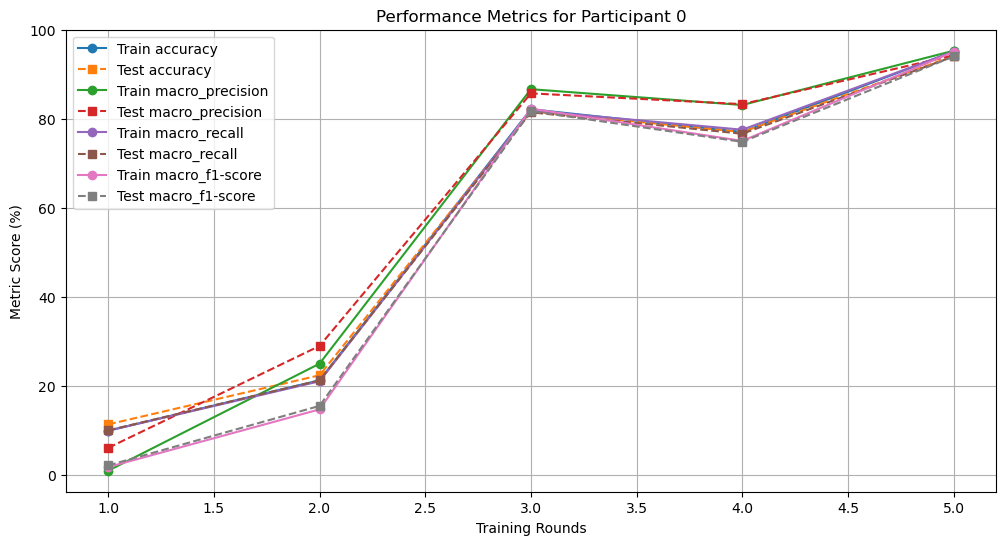

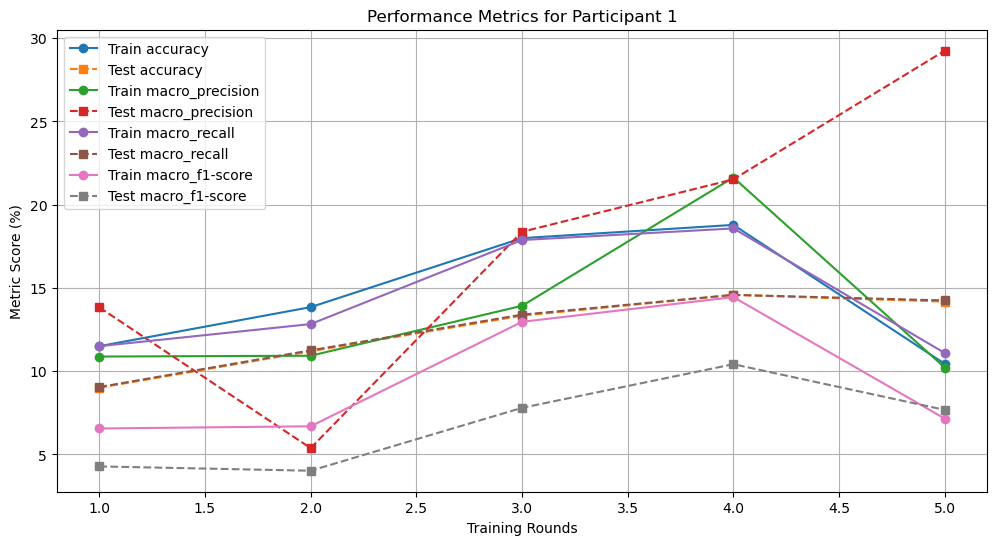

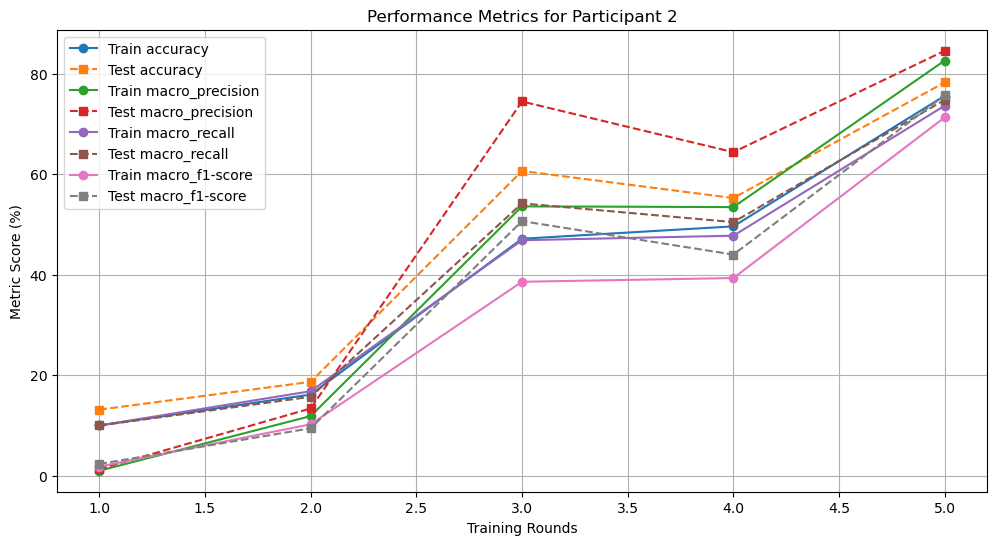

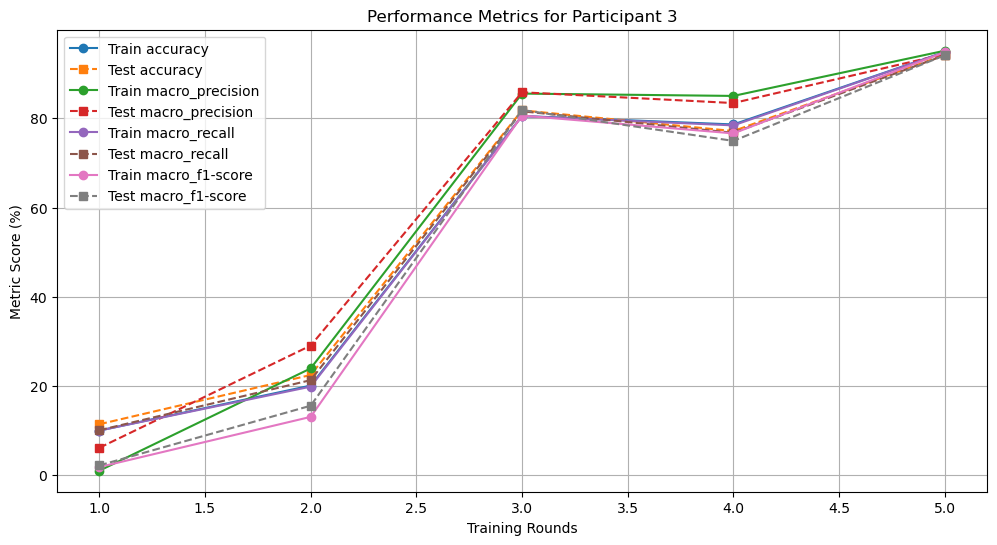

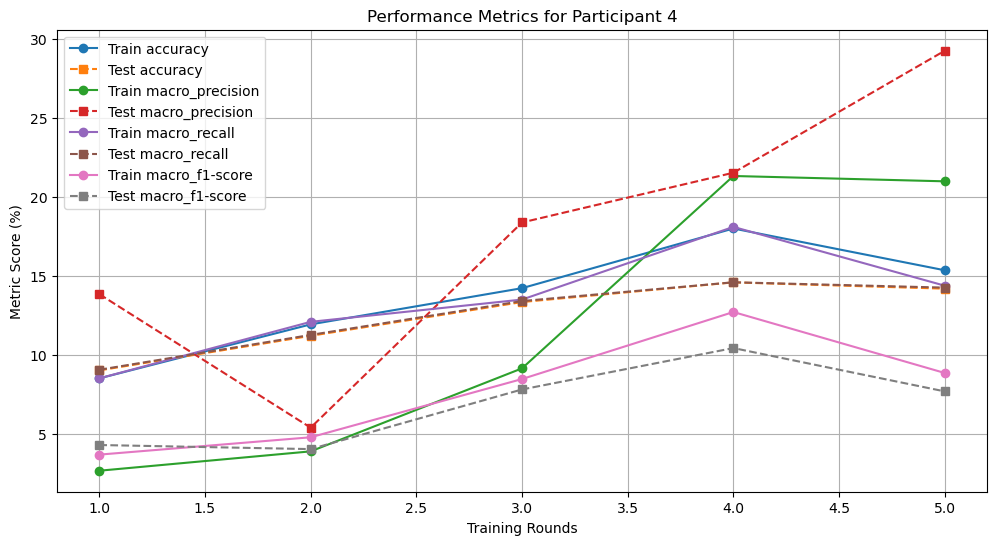

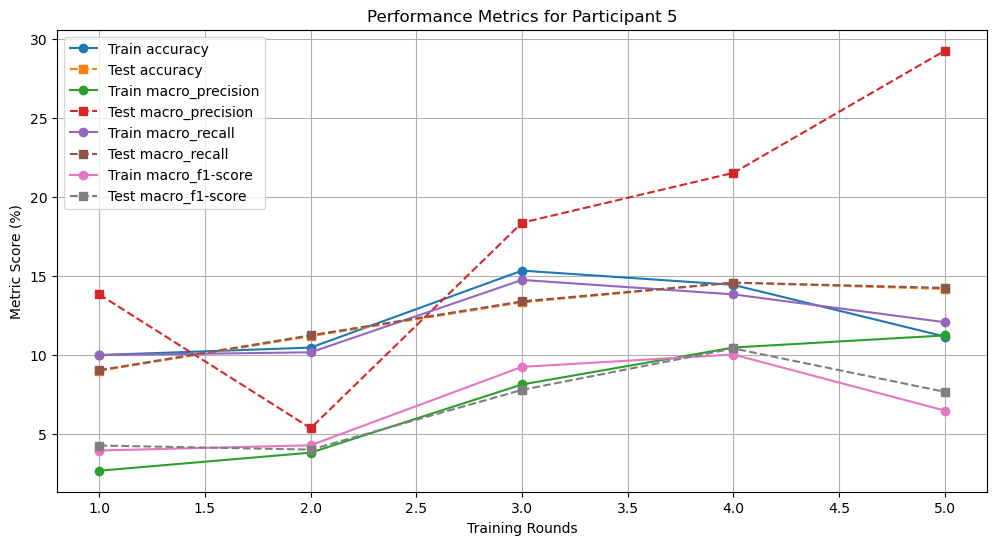

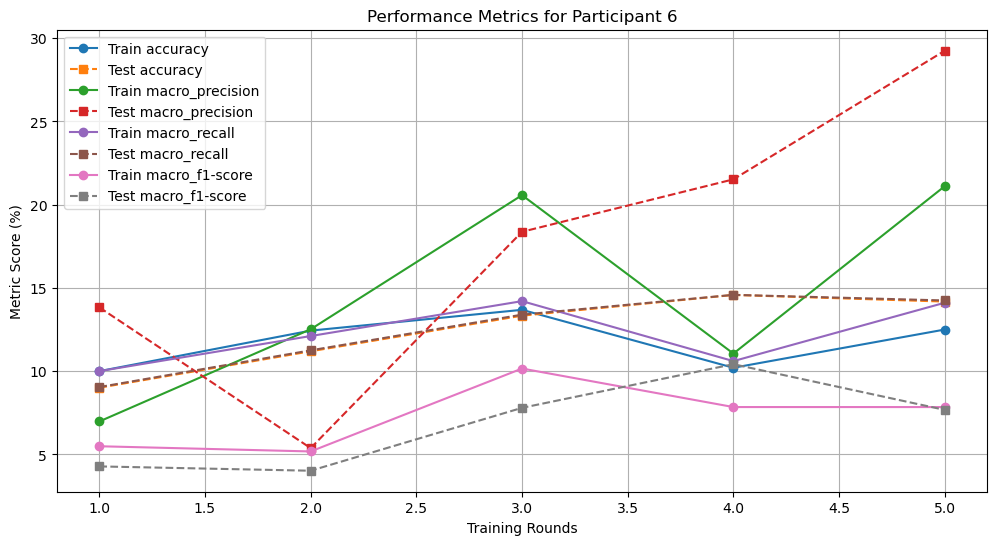

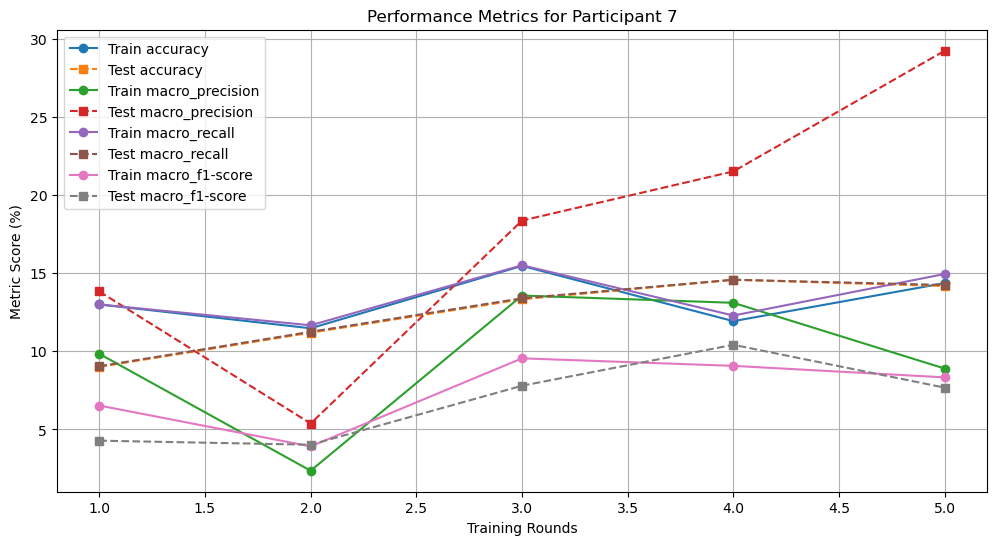

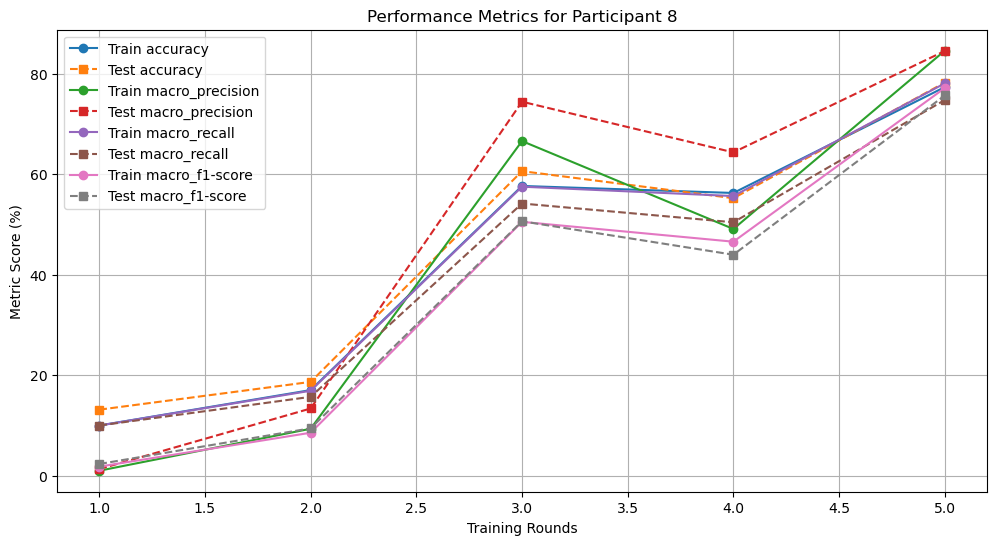

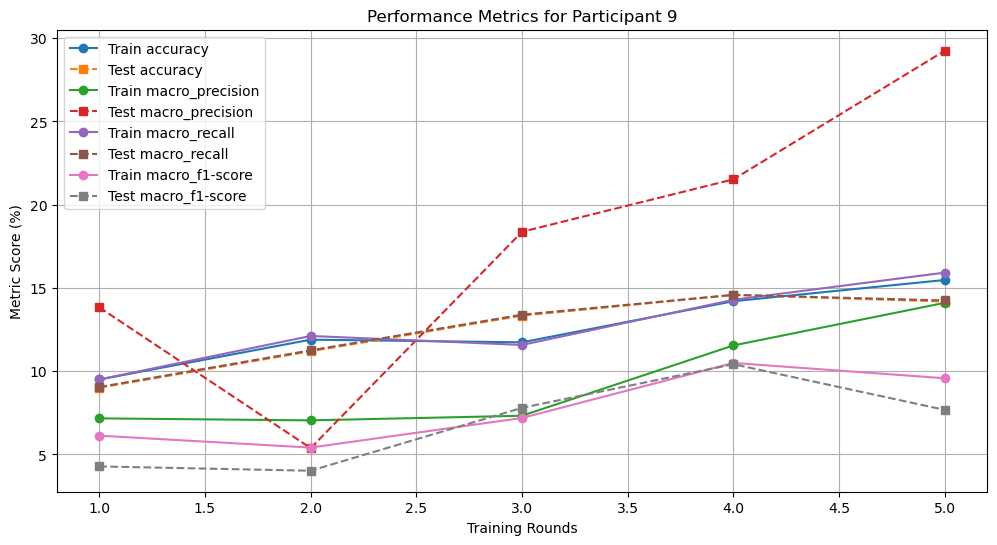

In [19]:
def plot_metrics(df):
    """
    Plot accuracy, precision, recall, and F1-score for each participant over rounds.

    Args:
        df (pd.DataFrame): DataFrame containing metrics for train and test.
    """
    metrics = ["accuracy", "macro_precision", "macro_recall", "macro_f1-score"]
    participants = df["Participant"].unique()

    for participant in participants:
        plt.figure(figsize=(12, 6))
        for metric in metrics:
            subset_train = df[(df["Participant"] == participant) & (df["Type"] == "Train")]
            subset_test = df[(df["Participant"] == participant) & (df["Type"] == "Test")]

            plt.plot(subset_train["Round"], subset_train[metric], label=f"Train {metric}", linestyle="-", marker="o")
            plt.plot(subset_test["Round"], subset_test[metric], label=f"Test {metric}", linestyle="--", marker="s")

        plt.xlabel("Training Rounds")
        plt.ylabel("Metric Score (%)")
        plt.title(f"Performance Metrics for Participant {participant}")
        plt.legend()
        plt.grid(True)
        plt.show()

# Call function to plot
plot_metrics(df_metrics)

In [26]:
import pandas as pd

def create_metrics_dfs(metrics_dict, metric_type="Train"):
    """
    Convert a dictionary of metrics into two Pandas DataFrames:
    1. Overall metrics (accuracy, macro_precision, macro_recall, macro_f1-score).
    2. Per-label metrics (accuracy, precision, recall, f1-score for each digit).
    
    Args:
        metrics_dict (dict): Dictionary where each key is a participant ID,
                             and value is a list of metric dictionaries.
        metric_type (str): "Train" or "Test" to label the dataset.
    
    Returns:
        tuple: (df_overall, df_per_label)
            - df_overall: DataFrame with overall metrics per participant and round.
            - df_per_label: DataFrame with per-digit metrics per participant and round.
    """
    overall_records = []
    per_label_records = []

    for participant, metrics_list in metrics_dict.items():
        for round_num, metrics in enumerate(metrics_list):
            round_index = round_num + 1  # 1-based index for rounds
            
            # Overall metrics
            overall_record = {
                "Participant": participant,
                "Round": round_index,
                "Type": metric_type,
                "Accuracy": metrics["accuracy"],
                "Macro Precision": metrics["macro_precision"],
                "Macro Recall": metrics["macro_recall"],
                "Macro F1-score": metrics["macro_f1-score"],
            }
            overall_records.append(overall_record)

            # Per-label metrics (per digit)
            per_label_metrics = metrics["per_label_metrics"]
            for digit in range(10):  # Digits 0-9
                per_label_record = {
                    "Participant": participant,
                    "Round": round_index,
                    "Type": metric_type,
                    "Digit": digit,
                    "Accuracy": per_label_metrics["accuracy"][digit],
                    "Precision": per_label_metrics["precision"][digit],
                    "Recall": per_label_metrics["recall"][digit],
                    "F1-score": per_label_metrics["f1-score"][digit],
                }
                per_label_records.append(per_label_record)

    # Convert lists to DataFrames
    df_overall = pd.DataFrame(overall_records)
    df_per_label = pd.DataFrame(per_label_records)

    return df_overall, df_per_label

In [27]:
# Convert train and test metrics to DataFrames
df_train_overall, df_train_per_label = create_metrics_dfs(model.local_metrics_train, metric_type="Train")
df_test_overall, df_test_per_label = create_metrics_dfs(model.local_metrics_test, metric_type="Test")

# Combine overall metrics into a single DataFrame
df_overall = pd.concat([df_train_overall, df_test_overall])

# Combine per-digit metrics into a single DataFrame
df_per_label = pd.concat([df_train_per_label, df_test_per_label])

# Display DataFrames
print(df_overall.head())   # General metrics
print(df_per_label.head()) # Per-digit metrics

   Participant  Round   Type   Accuracy  Macro Precision  Macro Recall  \
0            0      1  Train  10.000000         1.001669     10.000000   
1            0      2  Train  21.322314        25.070913     21.104806   
2            0      3  Train  82.273113        86.777564     81.983785   
3            0      4  Train  77.159468        83.222264     77.670730   
4            0      5  Train  95.253955        95.426077     95.247938   

   Macro F1-score  
0        1.820941  
1       14.787041  
2       82.414267  
3       75.149667  
4       95.165359  
   Participant  Round   Type  Digit  Accuracy  Precision  Recall   F1-score
0            0      1  Train      0       0.0   0.000000     0.0   0.000000
1            0      1  Train      1     100.0  10.016694   100.0  18.209408
2            0      1  Train      2       0.0   0.000000     0.0   0.000000
3            0      1  Train      3       0.0   0.000000     0.0   0.000000
4            0      1  Train      4       0.0   0.00000

In [32]:
import altair as alt

def plot_metrics_altair(df):
    """
    Create an interactive Altair chart with a dropdown menu to select participants.
    
    Args:
        df (pd.DataFrame): DataFrame containing metrics for train and test.
    """
    metrics = ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1-score"]

    # Convert metrics from wide format to long format for Altair
    df_long = df.melt(id_vars=["Participant", "Round", "Type"], 
                      value_vars=metrics, 
                      var_name="Metric", 
                      value_name="Score")

    # Create a selection dropdown for Participants (Fix: Use selection_point instead of selection_single)
    participant_dropdown = alt.binding_select(options=sorted(df["Participant"].unique()), name="Participant: ")
    participant_selection = alt.selection_point(fields=["Participant"], bind=participant_dropdown)

    # Line chart for train/test metrics
    chart = (
        alt.Chart(df_long)
        .mark_line(point=True)
        .encode(
            x=alt.X("Round:O", title="Training Rounds"),
            y=alt.Y("Score:Q", title="Metric Score (%)"),
            color=alt.Color("Type:N", title="Dataset Type", scale=alt.Scale(domain=["Train", "Test"], range=["blue", "red"])),
            strokeDash="Type:N",  # Dashed line for Test, Solid for Train
            tooltip=["Round", "Score", "Metric", "Type"],
            column="Metric:N"  # Separate plots for each metric
        )
        .transform_filter(participant_selection)  # Apply selection filter
        .add_selection(participant_selection)  # Add dropdown menu
    )

    return chart

# Generate the interactive Altair chart
plot_metrics_altair(df_overall)

alt.Chart(...)

In [33]:
import altair as alt

def plot_per_digit_metrics_altair(df):
    """
    Create an interactive Altair chart with dropdown menus for participants and digits.

    Args:
        df (pd.DataFrame): DataFrame containing per-digit metrics for train and test.
    """
    metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

    # Convert to long format for Altair
    df_long = df.melt(id_vars=["Participant", "Round", "Type", "Digit"], 
                      value_vars=metrics, 
                      var_name="Metric", 
                      value_name="Score")

    # Dropdown for selecting a participant
    participant_dropdown = alt.binding_select(options=sorted(df["Participant"].unique()), name="Participant: ")
    participant_selection = alt.selection_point(fields=["Participant"], bind=participant_dropdown)

    # Dropdown for selecting a digit
    digit_dropdown = alt.binding_select(options=sorted(df["Digit"].unique()), name="Digit: ")
    digit_selection = alt.selection_point(fields=["Digit"], bind=digit_dropdown)

    # Line chart with selection filters
    chart = (
        alt.Chart(df_long)
        .mark_line(point=True)
        .encode(
            x=alt.X("Round:O", title="Training Rounds"),
            y=alt.Y("Score:Q", title="Metric Score (%)"),
            color=alt.Color("Type:N", title="Dataset Type", scale=alt.Scale(domain=["Train", "Test"], range=["blue", "red"])),
            strokeDash="Type:N",  # Solid for Train, Dashed for Test
            tooltip=["Round", "Score", "Metric", "Type"],
            column="Metric:N"  # Separate plots for each metric
        )
        .transform_filter(participant_selection)  # Filter by participant
        .transform_filter(digit_selection)  # Filter by digit
        .add_selection(participant_selection)  # Add participant dropdown
        .add_selection(digit_selection)  # Add digit dropdown
    )

    return chart

# Generate the interactive Altair chart
plot_per_digit_metrics_altair(df_per_label)


alt.Chart(...)

In [16]:
len(model.local_history[0][0])

10

In [17]:
len(model.global_history[0])

10

In [18]:
for img, proto in model.global_protos.items():
    print(f'{img}: {proto[0].shape}')

3: torch.Size([1, 512])
6: torch.Size([1, 512])
1: torch.Size([1, 512])
9: torch.Size([1, 512])
4: torch.Size([1, 512])
0: torch.Size([1, 512])
8: torch.Size([1, 512])
7: torch.Size([1, 512])
2: torch.Size([1, 512])
5: torch.Size([1, 512])


In [19]:
for img, proto in model.local_protos.items():
    print(f'{img}: {proto[0].shape}')

0: torch.Size([512])
1: torch.Size([512])
2: torch.Size([512])
3: torch.Size([512])
4: torch.Size([512])
5: torch.Size([512])
6: torch.Size([512])


In [126]:
original_data = copy.deepcopy(avaliable_indexes[domain])

teste = copy.deepcopy(avaliable_indexes[domain])

In [18]:
# Define federation list
federation = []

# Client A
init_pop = 50
init_steps = 20
init_period = int(0.2 * init_pop)
init_freq = 1
max_comb = 6
init_rate = None
init_angular = None
domain = 'mnist'

add_participant_to_federation(
    federation=federation,
    available_indexes=avaliable_indexes[domain],
    init_pop=init_pop,
    init_steps=init_steps,
    init_freq=init_freq,
    init_period=init_period,
    init_rate = init_rate,
    init_angular = init_angular,
    max_comb=max_comb
)

Added new participant with 6 labels to the federation.


In [19]:
# Client B
init_pop = 50
init_steps = 20
init_period = int(0.2 * init_pop)
init_freq = None
max_comb = 5
init_rate = None
init_angular = None
domain = 'mnist'

add_participant_to_federation(
    federation=federation,
    available_indexes=avaliable_indexes[domain],
    init_pop=init_pop,
    init_steps=init_steps,
    init_freq=init_freq,
    init_period=init_period,
    init_rate = init_rate,
    init_angular = init_angular,
    max_comb=max_comb
)

Added new participant with 5 labels to the federation.


In [20]:
# Client C
init_pop = 50
init_steps = 20
init_period = None
init_freq = 1
max_comb = 8
init_rate = None
init_angular = None
domain = 'mnist'

add_participant_to_federation(
    federation=federation,
    available_indexes=avaliable_indexes[domain],
    init_pop=init_pop,
    init_steps=init_steps,
    init_freq=init_freq,
    init_period=init_period,
    init_rate = init_rate,
    init_angular = init_angular,
    max_comb=max_comb
)

Added new participant with 8 labels to the federation.


In [21]:
# Client D
init_pop = 50
init_steps = 20
init_period = None
init_freq = None
max_comb = 8
init_rate = None
init_angular = None
domain = 'mnist'

add_participant_to_federation(
    federation=federation,
    available_indexes=avaliable_indexes[domain],
    init_pop=init_pop,
    init_steps=init_steps,
    init_freq=init_freq,
    init_period=init_period,
    init_rate = init_rate,
    init_angular = init_angular,
    max_comb=max_comb
)

Added new participant with 8 labels to the federation.


In [22]:
# Client E
init_pop = 600
init_steps = 20
init_period = 0.0000001
init_freq = 0.0000001
max_comb = 8
init_rate = 0.00000001
init_angular = 0.00000001
domain = 'mnist'

add_participant_to_federation(
    federation=federation,
    available_indexes=avaliable_indexes[domain],
    init_pop=init_pop,
    init_steps=init_steps,
    init_freq=init_freq,
    init_period=init_period,
    init_rate = init_rate,
    init_angular = init_angular,
    max_comb=max_comb
)

Added new participant with 8 labels to the federation.


In [20]:
aux_plot = []
for i, part in enumerate(federation):
    aux_part = part.report_data()
    aux_part['Participant'] = f'Part_{i}'
    aux_part.rename(columns = {'id' : 'Digit'}, inplace = True)
    aux_plot.append(aux_part)

df_plot = pd.concat(aux_plot)

# Melt the DataFrame
df_plot = df_plot.melt(id_vars=['Digit', 'Participant'], 
                     var_name='Time', 
                     value_name='Count')

# Convert 'Time' to numerical values (e.g., value_1 → 1, value_2 → 2, etc.)
df_plot['Time'] = df_plot['Time'].str.extract('(\d+)').astype(int) - 1

df_plot.shape

(700, 4)

In [21]:
import altair as alt

def plot_mnist_distribution(plot_data, plot_width=800, plot_height=400):
    """
    Plot the MNIST distribution using a bar chart and heatmap, distributing the plot size
    between the bar chart and heatmap.

    Parameters:
    - plot_data: DataFrame with the MNIST data
    - plot_width: Total width of the final plot (default: 800)
    - plot_height: Total height of the final plot (default: 400)
    """

    # Create a slider for selecting 'Time'
    time_slider = alt.binding_range(
        min=plot_data['Time'].min(), 
        max=plot_data['Time'].max(), 
        step=1, 
        name="Select Time: "
    )
    time_param = alt.selection_point(bind=time_slider, fields=['Time'], value = plot_data['Time'].min())

    # Altair selection object for interactive filtering
    bar_point = alt.selection_point(encodings=['x'])
    client_selection = alt.selection_point(encodings=['y'])
    
    # Calculate the split dimensions for the two charts
    bar_width = plot_width * 0.4   # 40% of the width for the bar chart
    heatmap_width = plot_width * 0.6  # 60% of the width for the heatmap
    bar_height = plot_height       # Full height for the bar chart
    heatmap_height = plot_height   # Full height for the heatmap
    
    # Heatmap (Digit vs. Participant) filtered by selected Time
    heatmap = alt.Chart(plot_data).mark_rect().encode(
        x=alt.X('Digit:O', title="MNIST Digit (0-9)"),
        y=alt.Y('Participant:N', title="Participants"),
        color = alt.condition(
                bar_point, 
                alt.Color('Count:Q', scale=alt.Scale(scheme='greenblue'), title="Total Count", legend=alt.Legend(orient="top")),  
                alt.ColorValue("grey")  # Non-selected values will be grey
            ),
        tooltip=[alt.Tooltip('Digit:O', title="Digit"),
                 alt.Tooltip('Participant:N', title="Participant"),
                 alt.Tooltip('Count:Q', title="Total Count")]
    ).transform_filter(
        time_param
    ).add_params(bar_point, client_selection, time_param).properties(width=heatmap_width, height=heatmap_height)
    
    # Overlay points for highlighting
    highlight_points = heatmap.mark_point().encode(
        color=alt.ColorValue('black'),
        size=alt.Size('Count:Q', title="Selected Images")
    ).transform_filter(
        bar_point
    ).transform_filter(
        client_selection
    )
    
    
    # Bar chart (Total images per client_selectionicipant) filtered by selected Time
    bar_chart = alt.Chart(plot_data).mark_bar().encode(
        x="Participant:N",
        y="sum(Count):Q",
        color=alt.condition(bar_point, alt.ColorValue("steelblue"), alt.ColorValue("grey"))
    ).transform_filter(
        time_param
    ).add_params(bar_point).properties(width=bar_width, height=bar_height)


    # Create an Altair line chart with markers
    line_chart = alt.Chart(plot_data).mark_line().encode(
        x='Time:O',  # Ordinal axis for time
        y='Count:Q',  # Quantitative axis for process value
        color=alt.Color('Digit:O', title="Stoc.Process"),
        tooltip=['Digit', 'Time', 'Count']
    ).properties(
        title="Process over Time",
        width=300,
        height=plot_height
    ).transform_filter(
        bar_point
    ).transform_filter(
        client_selection
    )
    
    # Add markers (circles) at data points
    marker_chart = alt.Chart(plot_data).mark_circle(size=50).encode(
        x='Time:O',
        y='Count:Q',
        color=alt.Color('Digit:O', title="Stoc.Process"),
        tooltip=['Digit', 'Time', 'Count']
    ).transform_filter(
        bar_point
    ).transform_filter(
        client_selection
    )
    
    # Overlay the markers on top of the line chart
    chart = line_chart + marker_chart
    
    # Combine the charts horizontally
    final_chart = alt.hconcat(
        bar_chart,
        heatmap + highlight_points,
        chart
    ).resolve_legend(
        color="independent",
        size="independent"
    )

    return final_chart

# Example of using the function with custom plot size
final_chart = plot_mnist_distribution(plot_data=df_plot, plot_width=350, plot_height=250)
final_chart

alt.HConcatChart(...)

In [18]:
train_dataset_list[0].dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: C:/Users/arthu/USPy/0_BEPE/1_FPL/datasets/
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Lambda()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [19]:
train_dataset_list[0].dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [83]:
client_tgt = federation[0]

idxs_tgt = client_tgt.get_sample_step(0)
idxs_tgt[:5]

[1409, 2820, 58759, 49287, 17810]

In [85]:
from torch.utils.data import DataLoader, SubsetRandomSampler


train_sampler = SubsetRandomSampler(idxs_tgt)

tr_dl = DataLoader(train_dataset_list[0].dataset, batch_size=64, sampler=train_sampler)